In [1]:
import json
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

### Create TEM Env

In [33]:
def compute_similarity_matrix_from_ratings(rating_df):
    return rating_df.corr('pearson')

def get_locationID_to_category_from_MDS(similarity_matrix, random_seed, grid_size=11):
    """
   Assign categories to TEM env nodes based on their similarity to each other.
    
    :param similarity_matrix: DataFrame containing the similarity between each pair of categories from the rating data
    :param random_seed: Random seed for MDS initialization
    :param grid_size: The size of the grid for TEM env
    :return: A dictionary mapping each category to its node ID in the TEM env
   """

    # Compute MDS embedding
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_seed, metric=True)
    mds_result = mds.fit_transform(1 - similarity_matrix)

    # Normalize MDS coordinates to fit within [0, grid_size-1] without rounding
    x_min, x_max = mds_result[:, 0].min(), mds_result[:, 0].max()
    y_min, y_max = mds_result[:, 1].min(), mds_result[:, 1].max()

    scaled_coords = np.zeros_like(mds_result)
    scaled_coords[:, 0] = (mds_result[:, 0] - x_min) / (x_max - x_min) * (grid_size - 1)
    scaled_coords[:, 1] = (mds_result[:, 1] - y_min) / (y_max - y_min) * (grid_size - 1)

    # Generate all possible grid positions as (x, y) pairs
    grid_positions = np.array([(x, y) for y in range(grid_size) for x in range(grid_size)])
    kdtree = cKDTree(grid_positions)  # Build KD-tree for fast nearest-neighbor search

    used_positions = set()
    label_to_position = {}

    for idx, coord in enumerate(scaled_coords):
        label = similarity_matrix.columns[idx]

        # Find the nearest available grid position using City Block (L1) distance
        _, nearest_idx = kdtree.query(coord, p=1)
        x, y = grid_positions[nearest_idx]

        # Resolve conflicts if the position is already taken
        while (x, y) in used_positions:
            distances, nearest_indices = kdtree.query(coord, k=len(used_positions) + 2, p=1)  # Expand search

            # Find the first unoccupied position
            for idx in nearest_indices:
                x, y = grid_positions[idx]
                if (x, y) not in used_positions:
                    break

        used_positions.add((x, y))
        label_to_position[label] = (x, y)

    # Convert (x, y) positions to TEM env location IDs
    locationID_to_category = {}
    for label, (x, y) in label_to_position.items():
        location_id = (grid_size-1-y) * grid_size + x #+ 1  # Convert (x, y) to TEM env ID
        locationID_to_category[location_id] = label

    return locationID_to_category


def envLoc_beh_similarity(locationID_to_category, original_similarity_matrix, grid_size = 11):
    """
    Calculate the similarity between category relations in TEM env created and the rating data
    :param locationID_to_category: a dictionary mapping location ID to its category
    :param original_similarity_matrix: the original behavioral similarity matrix
    :param grid_size: the size of the grid for TEM env
    :return: the Spearman correlation
    """
    # Function to convert a location ID to grid coordinates (row, col)
    def location_to_coordinates(location_id, grid_size):
        row = location_id // grid_size
        col = location_id % grid_size
        return row, col
    # Get the coordinates of each category
    category_to_coordinates = {}
    for location_id, category in locationID_to_category.items():
        category_to_coordinates[category] = location_to_coordinates(location_id, grid_size)
    # Calculate the Manhattan distance similarity matrix
    categories = list(locationID_to_category.values())
    num_categories = len(categories)
    env_dissimilarity_matrix = np.zeros((num_categories, num_categories))

    for i, category1 in enumerate(categories):
        for j, category2 in enumerate(categories):
            coord1 = category_to_coordinates[category1]
            coord2 = category_to_coordinates[category2]
            manhattan_distance = abs(coord1[0] - coord2[0]) + abs(coord1[1] - coord2[1])
            env_dissimilarity_matrix[i, j] = manhattan_distance
    # Match order of categories in the env similarity matrix to the order in the original similarity matrix
    ordered_categories = list(original_similarity_matrix.columns)

    # Reorder the similarity matrix according to the desired order
    ordered_indices = [categories.index(cat) for cat in ordered_categories]
    reordered_env_dissimilarity_matrix = env_dissimilarity_matrix[np.ix_(ordered_indices, ordered_indices)]

    original_similarity_matrix_upper = np.triu(original_similarity_matrix, k=1)
    reordered_env_dissimilarity_matrix_upper = np.triu(reordered_env_dissimilarity_matrix, k=1)

    #calculate spearman correlation between similarity_matrix and reordered_env_dissimilarity_matrix
    return spearmanr(original_similarity_matrix_upper.flatten(), reordered_env_dissimilarity_matrix_upper.flatten()).correlation

def get_locationID_to_category_with_min_envLoc_beh_dissimilarity(rating_similarity_matrix, n_seeds=500):
    """
    Find the locationID to category mapping that maximizes the similarity between the TEM env and the rating data (lowest correlation between the dissimilarity and similarity matrices)
    :param rating_similarity_matrix: the behavioral similarity matrix
    :param n_seeds: the number of random seeds to try
    :return: the locationID to category mapping that maximizes the similarity, the random seed used, and the correlation
    """
    min_corr, min_corr_seed = float('inf'), np.nan
    for i in range(n_seeds):
        current_locationID_to_category = get_locationID_to_category_from_MDS(rating_similarity_matrix, random_seed=i)
        corr = envLoc_beh_similarity(current_locationID_to_category, rating_similarity_matrix)
        
        if corr < min_corr:
            min_corr, min_corr_seed = corr, i
            locationID_to_category_with_min_envLoc_beh_dissimilarity = current_locationID_to_category
    return locationID_to_category_with_min_envLoc_beh_dissimilarity, min_corr_seed, min_corr
            
        
def create_tem_env_dict(locationID_to_category, old_json_path):
    # Load the original env json
    with open(old_json_path, 'r') as f:
        env_dict = json.load(f)
    # set an 'empty' category for the locations that are not specified 
    locationID_to_category_withempty = locationID_to_category.copy()
    locationID_to_category_withempty.update({i: 'empty' for i in range(env_dict['n_locations']) if i not in locationID_to_category.keys()})

    n_emo = len([i for i in locationID_to_category_withempty.values() if i != 'empty'])
    assert list(set(locationID_to_category_withempty.keys())) == [i for i in range(env_dict['n_locations'])], "Incorrect location IDs"
    assert n_emo == 13, "Incorrect number of emo locations"
    assert env_dict['n_locations'] == 121, "Incomplete number of locations"

    # Randomly assign UNIQUE and 45-d one-hot observations to emo locations
    emo_obs = np.random.choice(range(env_dict['n_observations']), n_emo, replace=False).tolist()
    # Randomly assign 45-d one-hot observations to empty locations and not make them overlap with obs in emo locations
    empty_obs = np.random.choice([obs for obs in range(env_dict['n_observations']) if obs not in emo_obs], env_dict['n_locations'] - n_emo, replace=True).tolist()

    locationID_to_obs = {k: emo_obs.pop() if v != 'empty' else empty_obs.pop() for k, v in locationID_to_category_withempty.items()}
    assert len(emo_obs) == 0
    assert len(empty_obs) == 0
    # Update the env json
    for i, location_dict in enumerate(env_dict['locations']):
        location_dict['observation'] = locationID_to_obs[i]
        location_dict['category'] = locationID_to_category_withempty[i]  
    assert len(set([location['observation'] for location in env_dict['locations'] if location['category'] != 'empty'])) == len([location['observation'] for location in env_dict['locations'] if location['category'] != 'empty']), "Emo observations are not unique"
    assert all([0 <= location['observation'] <= 44 for location in env_dict['locations']]), "Observations are not within 45-d space"
    assert set([location['observation'] for location in env_dict['locations'] if location['category'] != 'empty']).isdisjoint(set([location['observation'] for location in env_dict['locations'] if location['category'] == 'empty'])), "Emo and empty observations overlap"
    assert  locationID_to_category_withempty == {i: location['category'] for i, location in enumerate(env_dict['locations'])}, "LocationID to category mapping is incorrect"
    return env_dict 


def mds_plot(similarity_matrix, seed, grid_size = 11, title=None,save=None, fontsize=25):
    plt.rcParams.update({'font.size': 30})

    
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=seed, metric=True)
    mds_result = mds.fit_transform(1 - similarity_matrix)
    
    plt.figure(figsize=(15, 15))
    #plot MDS points
    plt.scatter(mds_result[:, 0], mds_result[:, 1], s=800, c='orange', linewidth=2)

    #add labels to each point
    for i, txt in enumerate(similarity_matrix.columns):
        if txt == 'Happiness':
            #move label left
            plt.annotate(txt, (mds_result[i, 0]-0.5, mds_result[i, 1]), fontsize=fontsize, weight='bold')
        elif txt == 'Disgust':
            plt.annotate(txt, (mds_result[i, 0]-0.3, mds_result[i, 1]), fontsize=fontsize, weight='bold')
        elif txt == 'Anxiety' or txt == 'Anger':
            plt.annotate(txt, (mds_result[i, 0]-0.2, mds_result[i, 1]), fontsize=fontsize, weight='bold')
        else:
            plt.annotate(txt, (mds_result[i, 0], mds_result[i, 1]), fontsize=fontsize, weight='bold')


    #split the grid into 11x11 based on min and max values of MDS result
    plt.xticks(np.linspace(mds_result[:, 0].min(), mds_result[:, 0].max(), grid_size))
    plt.yticks(np.linspace(mds_result[:, 1].min(), mds_result[:, 1].max(), grid_size))
    

    #remove tick labels but not grid
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    #remove border of grid
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    plt.grid(True, which='both', linestyle='-', linewidth=2, color='gray', alpha=0.5)

    #plt.xlabel('MDS Dimension 1', fontsize=25)
    #plt.ylabel('MDS Dimension 2', fontsize=25)
    #spcify title and position
    if title:
        plt.title(f'Classic MDS for {title}', fontsize=25, pad=20)
    if save:
        plt.savefig(save, dpi=600)
    plt.show()
    
    

In [3]:
rating_data = json.load(open('./data/behTab_json.json'))
movie_names = list(rating_data.keys())
old_env_json_path = './TEMcode/2024-10-22/run0/script/envs/11x11_square_obs45_act5.json'
movie_names_to_remove = ['DamagedKungFu', 'RidingTheRails','LeassonLearned']
movie_names = [movie for movie in movie_names if movie not in movie_names_to_remove]  
rating_similarity_matrix = compute_similarity_matrix_from_ratings(pd.concat([pd.DataFrame(rating_data[movie]) for movie in movie_names]))
        
locationID_to_category, seed, corr = get_locationID_to_category_with_min_envLoc_beh_dissimilarity(rating_similarity_matrix, n_seeds=500)
env_dict = create_tem_env_dict(locationID_to_category, old_env_json_path)
env_path =  f'./TEMenvs/emofilm/11x11_13categories_MDSseed{seed}_14brainmovies.json'
#save json 
#with open(env_path, 'w') as f:
#   json.dump(env_dict, f)

print(seed, corr)
locationID_to_category

/home/yma/envs/netana_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/yma/envs/netana_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/yma/envs/netana_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/yma/envs/netana_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppres

121 -0.3062580139535373


/home/yma/envs/netana_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/yma/envs/netana_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


{31: 'Anger',
 29: 'Anxiety',
 16: 'Fear',
 52: 'Surprise',
 8: 'Guilt',
 43: 'Disgust',
 4: 'Sad',
 66: 'Regard',
 114: 'Satisfaction',
 78: 'WarmHeartedness',
 113: 'Happiness',
 101: 'Pride',
 56: 'Love'}

In [3]:
import json
import glob


envs_dir = './TEMenvs/emofilm/'
envs = list(glob.glob(envs_dir + '11x11_13categories_MDSseed121_14brainmovies.json'))

env_file = open(envs[0], 'r')
env_json = json.load(env_file)
emo_obs = [location['observation'] for location in env_json['locations'] if location['category'] != 'empty']
all_obs = [i for i in range(env_json['n_locations'])]
obs_to_include = emo_obs


locationID_to_category = {env_json['locations'][i]['id']: env_json['locations'][i]['category'] for i in range(env_json['n_locations']) if env_json['locations'][i]['observation'] in obs_to_include}
locationID_to_category

{4: 'Sad',
 8: 'Guilt',
 16: 'Fear',
 29: 'Anxiety',
 31: 'Anger',
 43: 'Disgust',
 52: 'Surprise',
 56: 'Love',
 66: 'Regard',
 78: 'WarmHeartedness',
 101: 'Pride',
 113: 'Happiness',
 114: 'Satisfaction'}

/home/yma/envs/netana_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


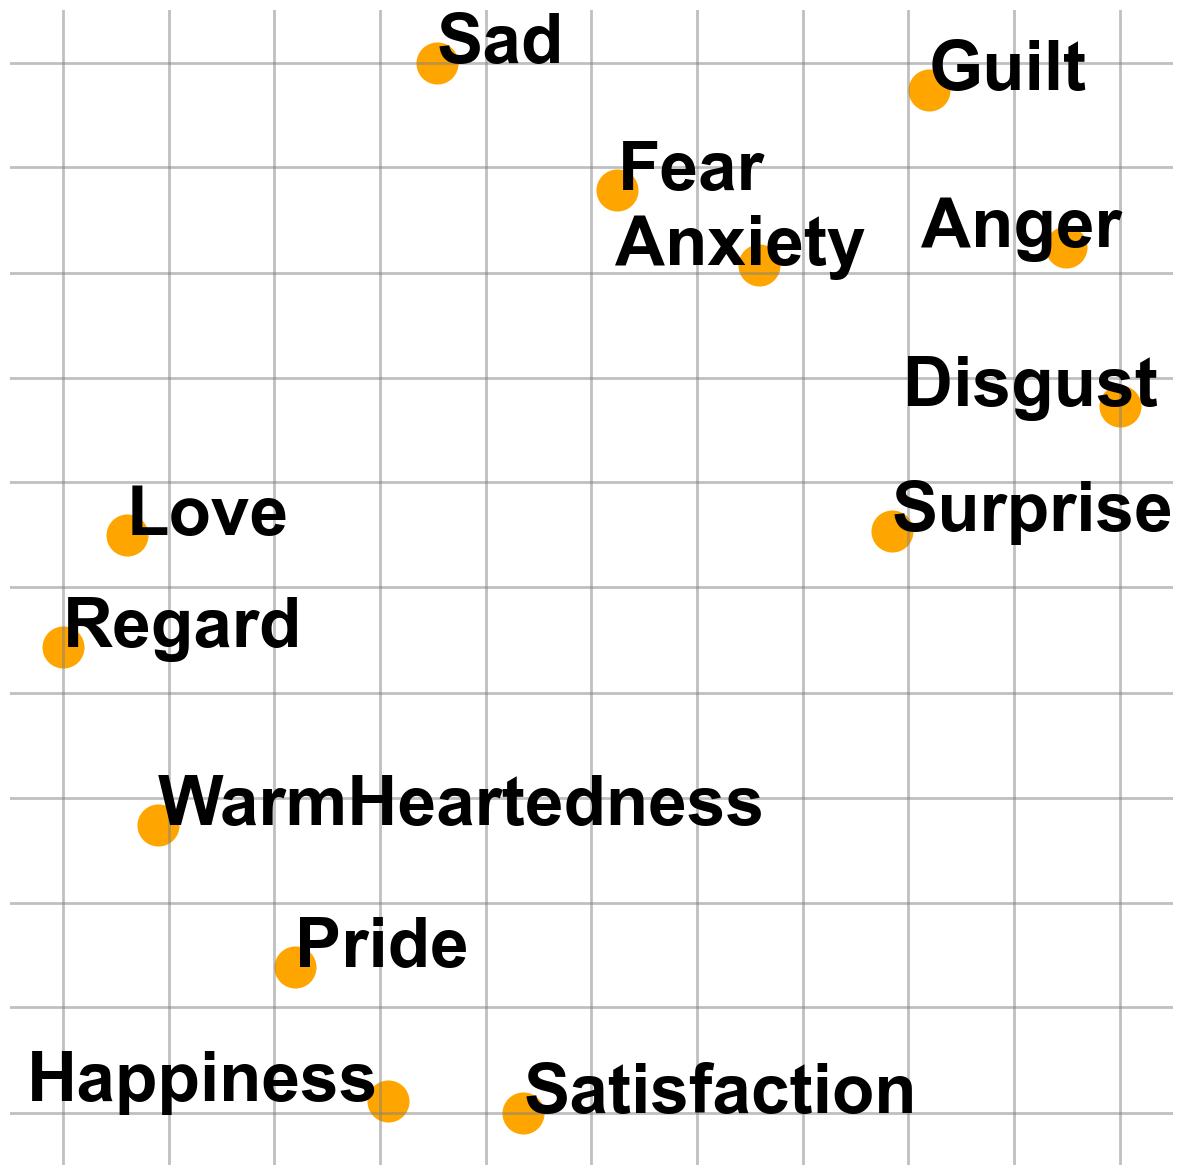

In [34]:
mds_plot(rating_similarity_matrix, seed,
         save = './outputs/rating_MDS_fontlarger.jpeg', fontsize=50)#,title='Category Ratings Concatenated across Movies')

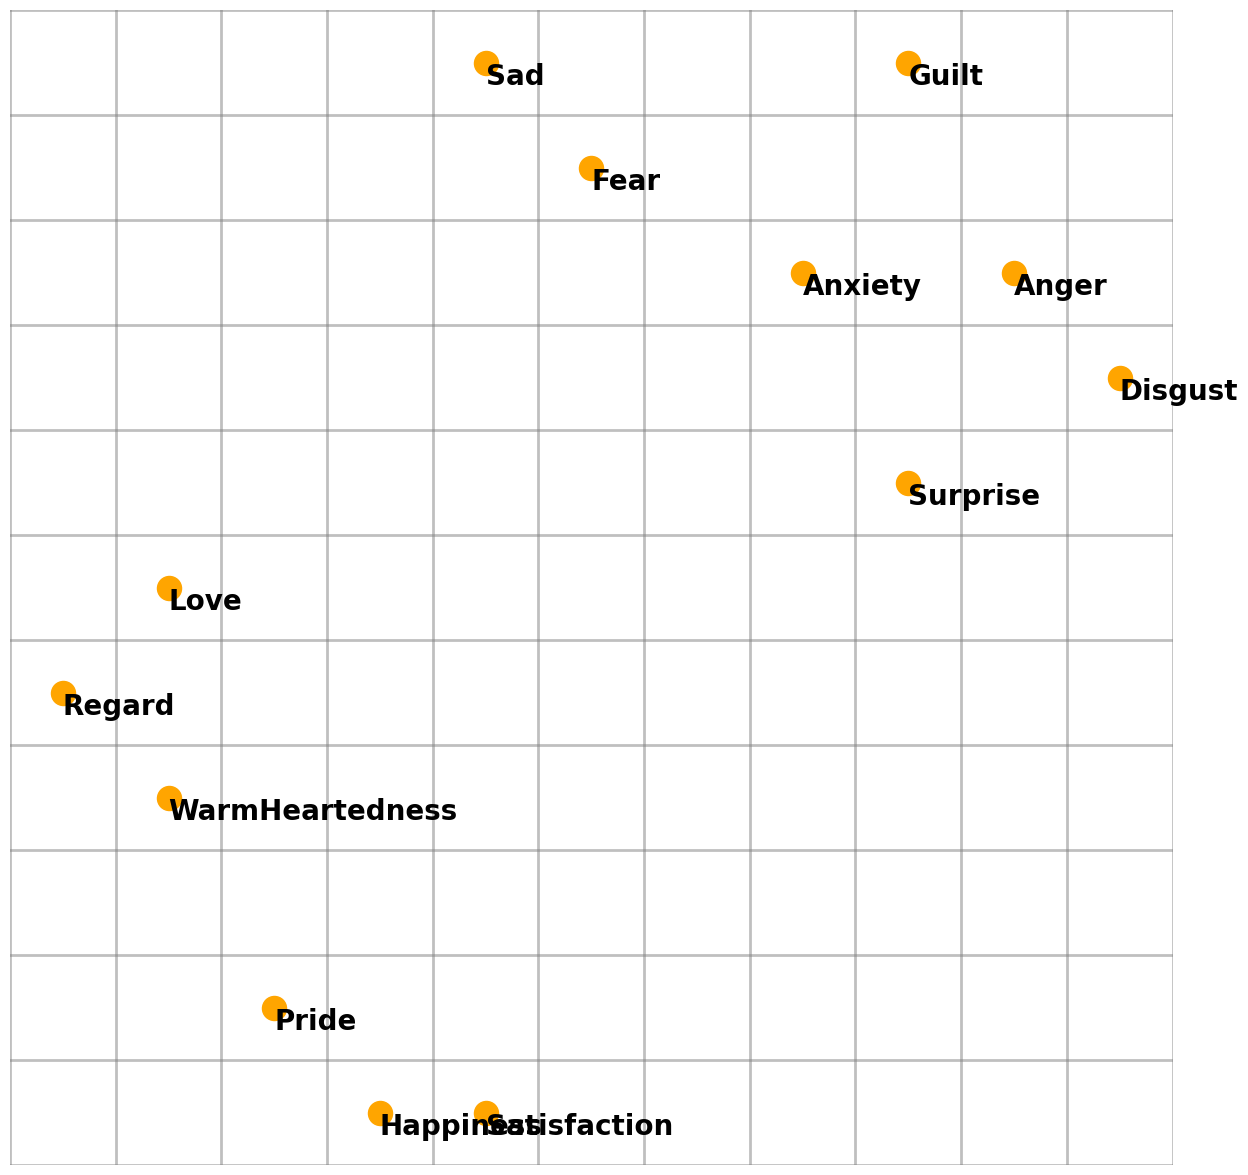

In [5]:

# Convert locationID to centered (x, y) coordinates
x_coords = [(loc % 11)+0.5 for loc in locationID_to_category.keys()]
y_coords = [10-(loc // 11)+0.5 for loc in locationID_to_category.keys()]
categories = list(locationID_to_category.values())

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(x_coords, y_coords, c="blue", s=100)  # Scatter plot
ax.set_xticks(range(12))  # Ensure ticks align with the grid
ax.set_yticks(range(12))
ax.grid(True, linestyle="--", alpha=0.6)

# Annotate each point with its category
for x, y, label in zip(x_coords, y_coords, categories):
    #ax.text(x, y, label, fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    #plot scatter and add label to each point
    ax.scatter(x, y, c='orange', s=300)
    ax.text(x, y, label, fontsize=20, ha='left', va='top', weight='bold', color='black')
    


ax.set_xlim(0, 11)
ax.set_ylim(0, 11)

#ax.set_title("TEM environment", fontsize=25)
#remove border of grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#remove tick labels but not grid
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.grid(True, which='both', linestyle='-', linewidth=2, color='gray', alpha=0.5)
plt.show()


#plt.gca().invert_yaxis()  # Optional: Ensure (0,0) starts at the top-left like an image



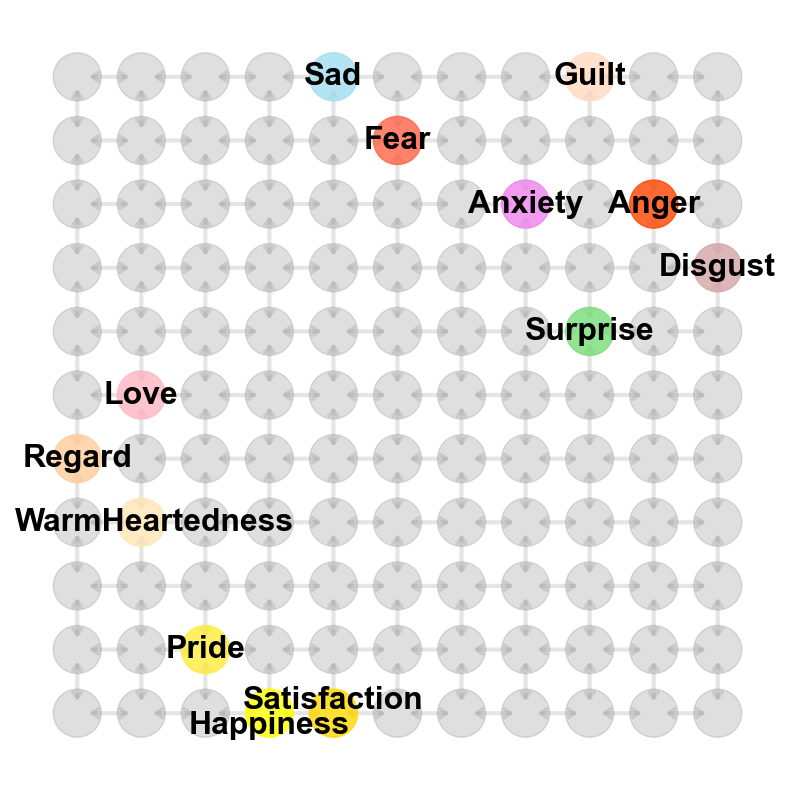

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
grid_size = 11
category_to_color = {
    'Anger': 'orangered',     
    'Anxiety': 'violet',        
    'Fear': 'tomato',       
    'Surprise': '#77DD77',    
    'Guilt': '#FFDAC1',        
    'Disgust': '#D4A5A5',      
    'Sad': '#A2DDF0',       
    'Regard': '#FFCC99',     
    'Satisfaction': '#FFD700',
    'WarmHeartedness': '#FFE5B4',
    'Happiness': '#FFFF00',   
    'Pride': '#FFEB3B',     
    'Love': '#FFB6C1'
}
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

G = nx.grid_2d_graph(grid_size, grid_size)

# Create a mapping from (row, col) to node ID
pos = {(x, y): (y, (grid_size - 1 - x)) for x, y in G.nodes()}

node_colors = []
node_alphas = []  
labels = {}      
for node in G.nodes():
    node_id = node[0] * grid_size + node[1]
    if node_id in locationID_to_category:
        emotion = locationID_to_category[node_id]
        node_colors.append(category_to_color.get(emotion, 'gray'))
        node_alphas.append(0.8)  
        labels[node] = emotion   
    else:
        node_colors.append('gray')
        node_alphas.append(0.25) 

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=1200,  
    alpha=node_alphas  
)

# Draw edges with bidirectional arrows
nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle="<->,head_length=0.2,head_width=0.15",  # Use bidirectional arrows
    arrowsize=20,      
    edge_color="gray", 
    width=3,           
    alpha=0.2,         
    arrows=True,
)
label_pos = pos.copy()  

# Move only Satisfaction's label upward
for node, emotion in labels.items():
    if emotion == 'Satisfaction':
        x, y = pos[node]
        label_pos[node] = (x, y + 0.2)
    elif emotion == 'Happiness':
        x, y = pos[node]
        label_pos[node] = (x, y - 0.2)
    elif emotion == 'WarmHeartedness':
        x, y = pos[node]
        label_pos[node] = (x+0.2, y)
nx.draw_networkx_labels(
    G,
    label_pos,     
    labels,        
    font_size=23,  
    font_color='black', 
    font_weight='bold'  
)

plt.axis("off")
plt.savefig('./outputs/TEM_env_graph_fontlarger.jpeg', dpi=600)
plt.show()


### Plot rate maps

In [1]:
import sys
sys.path.append('TEMcode/2024-10-22/run0/script')

import importlib
import src.analyse as analyse
import src.plot as plot
import src.world as world
import random
import glob
import os
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


def load_model(date, run, index, tem_dir):
    # Load the model: use import library to import module from specified path
    model_spec = importlib.util.spec_from_file_location("model", tem_dir + date + '/run' + run + '/script/src/model.py')
    model = importlib.util.module_from_spec(model_spec)
    model_spec.loader.exec_module(model)
    # Load the parameters of the model
    params = torch.load(tem_dir + date + '/run' + run + '/model/params_' + index + '.pt', map_location=torch.device('cpu'))
    new_params = {'device':'cpu'}
    for key in new_params:
        params[key] = new_params[key]

    # Create a new tem model with the loaded parameters
    tem = model.Model(params)
    # Load the model weights after training
    model_weights = torch.load(tem_dir + date + '/run' + run + '/model/tem_' + index + '.pt', map_location=torch.device('cpu'))
    # Set the model weights to the loaded trained model weights
    tem.load_state_dict(model_weights)
    return tem

random.seed(42)
date =  '2024-10-22' # '2020-10-13' 
run = '0' # '0'
index = 42000
random.seed(42)
##min_index = 200000
#max_index = 200000 # '32000'
#its_to_process = list(range(min_index, max_index, 1000))+[max_index]

# Make list of all the environments that this model was trained on
envs_dir = './TEMenvs/emofilm/'
envs = list(glob.glob(envs_dir + '11x11_13categories_MDSseed121_14brainmovies.json'))#list(glob.glob(envs_dir + '*.json'))
tem_dir = './TEMcode'
params = torch.load(tem_dir + date + '/run' + run + '/model/params_' + str(index) + '.pt', map_location=torch.device('cpu'))


env_to_plot = 0
env_file = open(envs[env_to_plot], 'r')
env_json = json.load(env_file)
emo_obs = [location['observation'] for location in env_json['locations'] if location['category'] != 'empty']
all_obs = [i for i in range(env_json['n_locations'])]
obs_to_include = emo_obs

obs_to_category = {env_json['locations'][i]['observation']: env_json['locations'][i]['category'] for i in range(env_json['n_locations']) if env_json['locations'][i]['observation'] in obs_to_include}
# Set which environments will include shiny objects
shiny_envs = [False]
# Set the number of walks to execute in parallel (batch size)
n_walks = len(shiny_envs)
# Select environments from the environments included in training
environments = [world.World(graph, randomise_observations=False, shiny=None) 
                for env_i, graph in enumerate([envs[env_to_plot]])]
# Determine the length of each walk
walk_len = np.median([env.n_locations * 100 for env in environments]).astype(int)
n_steps_removed = int(walk_len/2)#env_json['n_locations'] #remove the first n_locations steps from analysis for TEM to see all nodes to stabilize
# And generate walks for each environment
walks = [env.generate_walks(walk_len, 1)[0] for env in environments]
model_input = [[[[walks[i][j][k]][0] for i in range(len(walks))] for k in range(3)] for j in range(walk_len)]
for i_step, step in enumerate(model_input):
    model_input[i_step][1] = torch.stack(step[1], dim=0)

tem = load_model(date, run, str(index), tem_dir)
tem.eval() 
with torch.no_grad():
    forward = tem(model_input, prev_iter=None)

g, p = analyse.rate_map(forward, tem, environments)
from_acc, to_acc = analyse.location_accuracy(forward, tem, environments)
occupation = analyse.location_occupation(forward, tem, environments)

(<Figure size 1800x6000 with 150 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >,
         <Axes: title={'center': 'g cells, frequency 0'}>, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >,
         <Axes: title={'center': 'g cells, frequency 1'}>, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
    

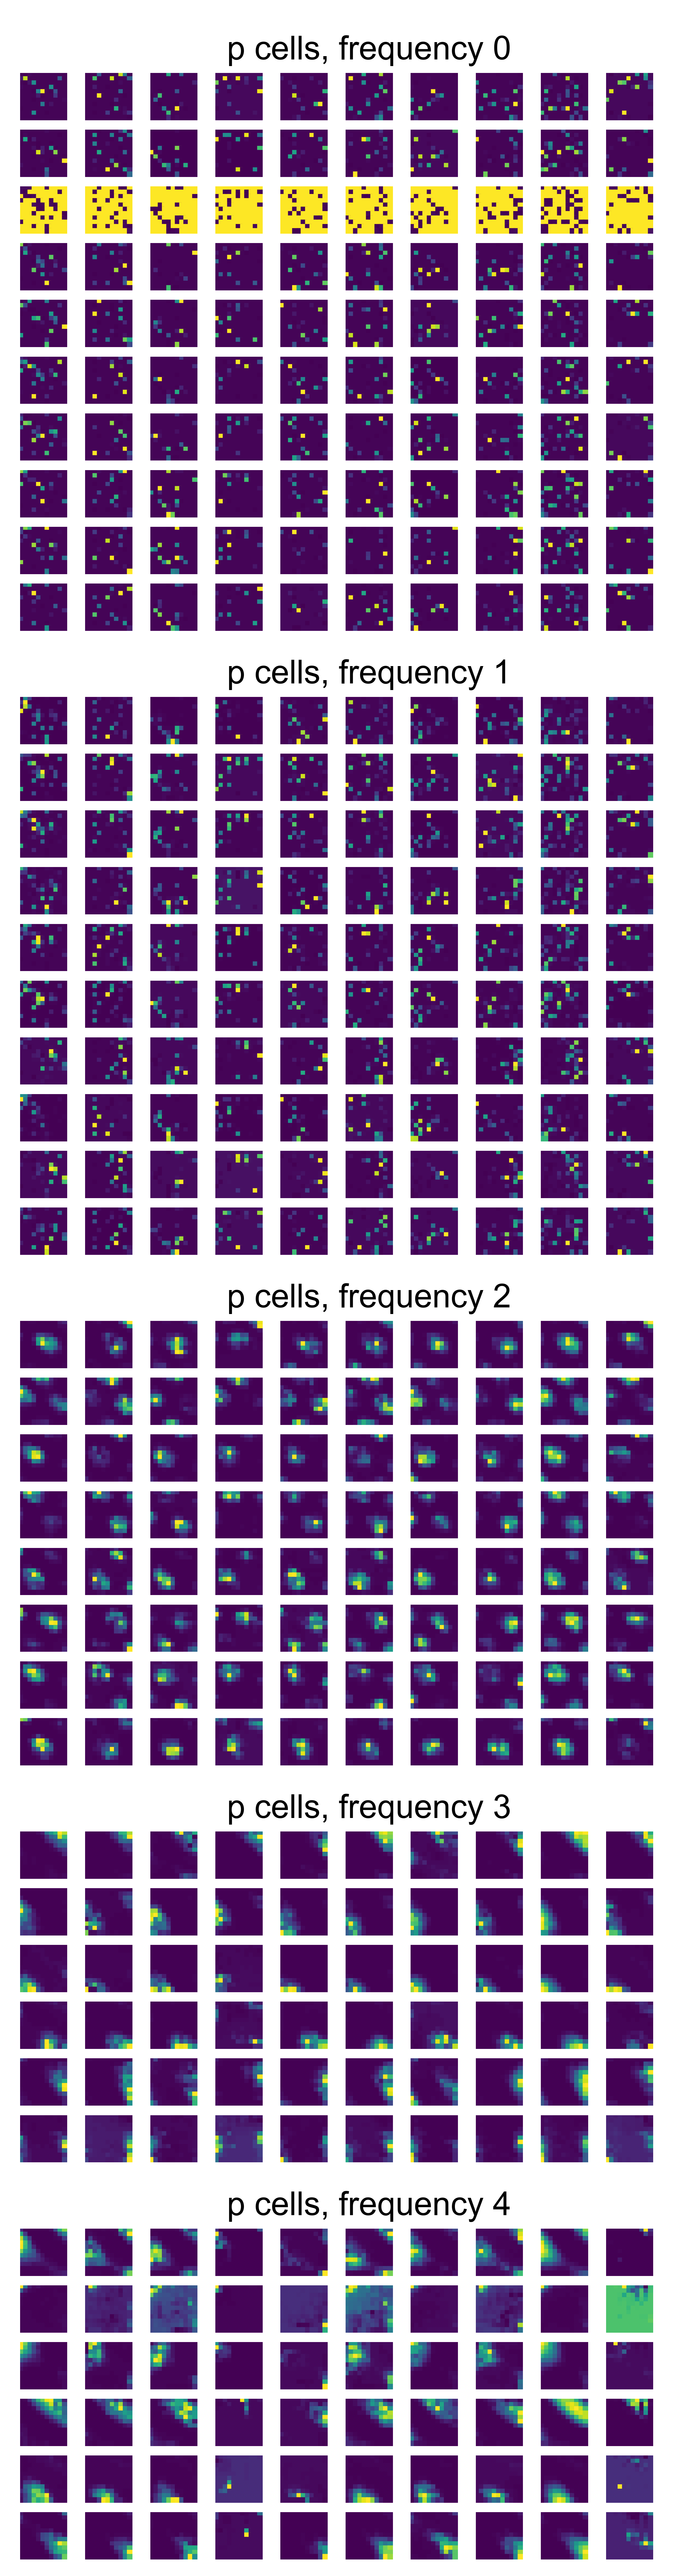

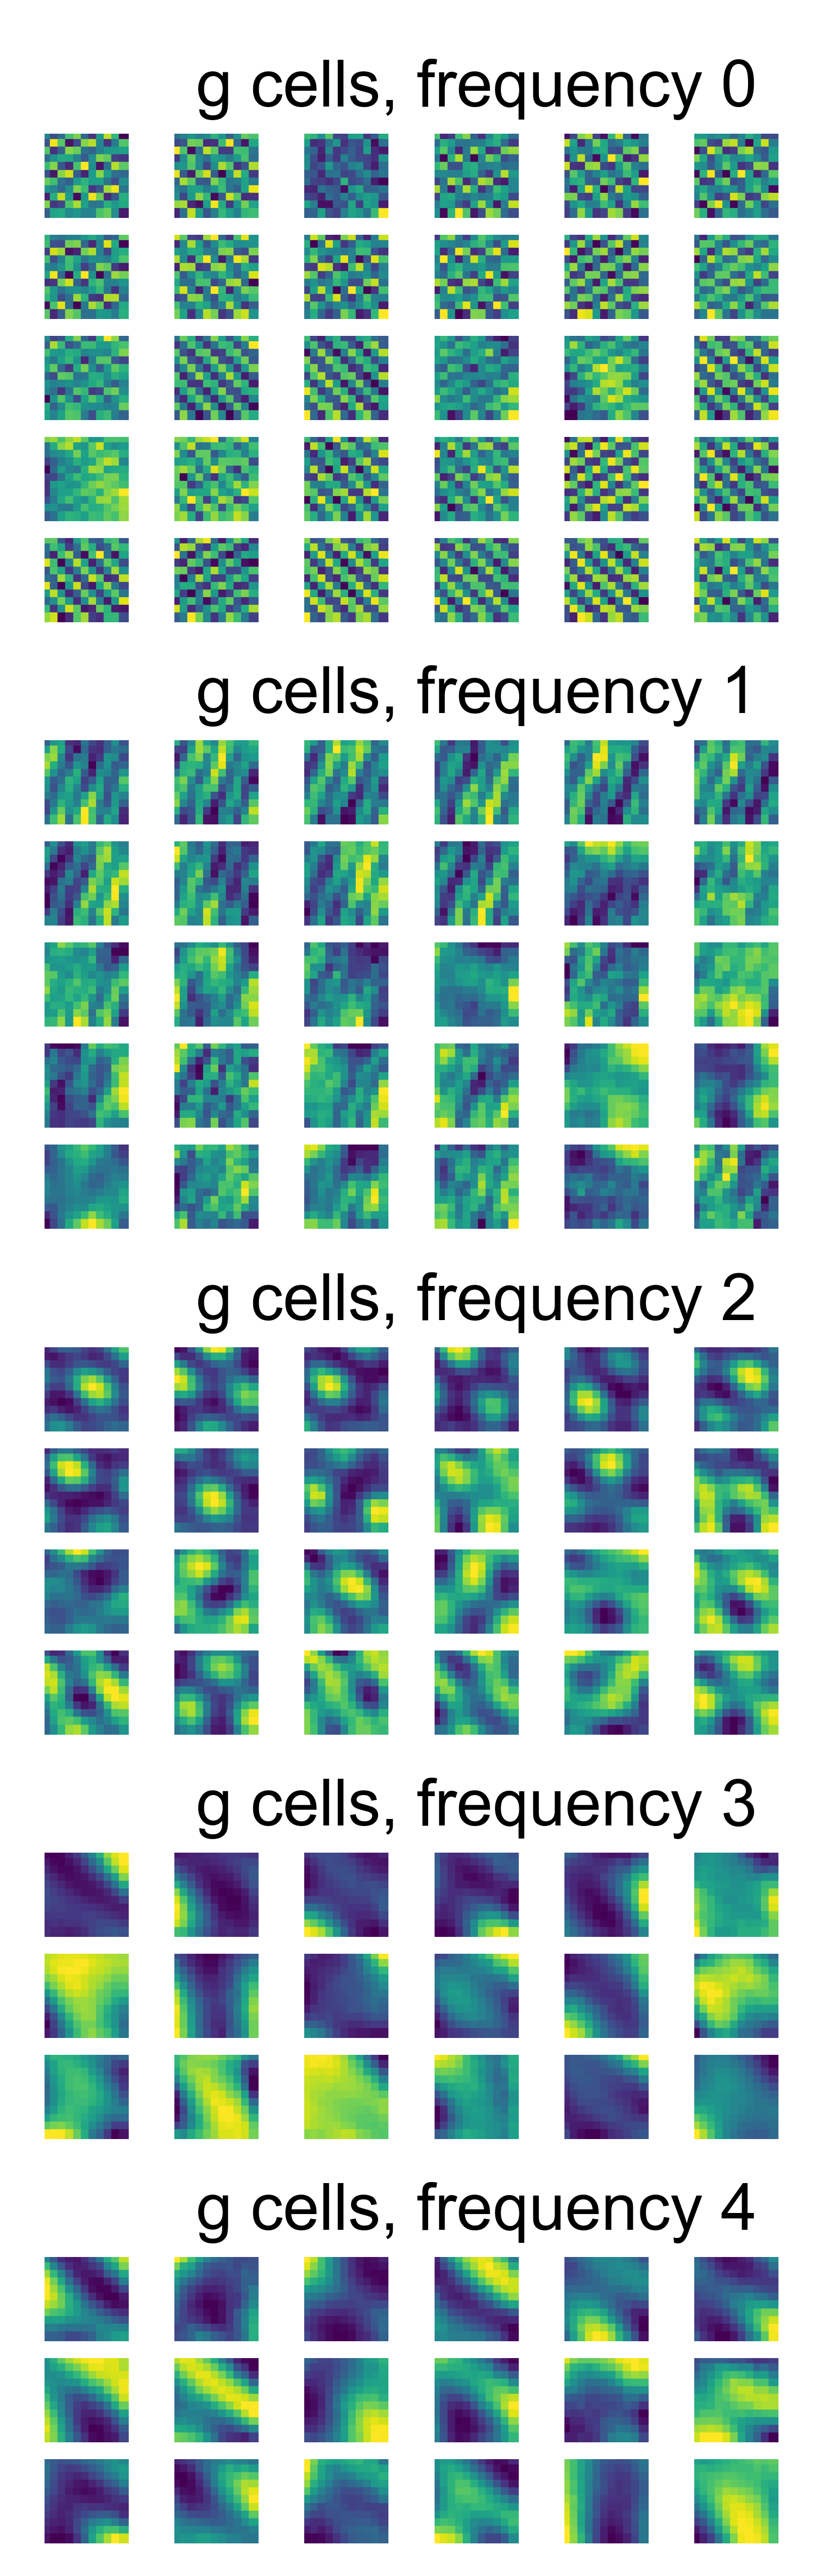

In [3]:
#change font size setting
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plot.plot_cells(p[env_to_plot], g[env_to_plot], environments[env_to_plot], n_f_ovc=(params['n_f_ovc'] if 'n_f_ovc' in params else 0), 
                columns_pg = [10,6],figsize_pg=[(5,20),(3,10)],
                save = ['./outputs/TEM_ratemaps_p.jpeg', './outputs/TEM_ratemaps_g.jpeg'])

Text(0.5, 1.0, 'Accuracy from location')

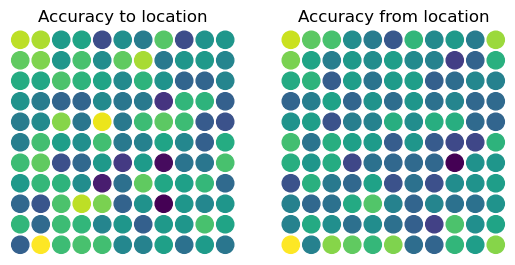

In [11]:
# Plot accuracy separated by location
plt.rcParams.update({'font.size': 10})
plt.figure()
ax = plt.subplot(1,2,1)
plot.plot_map(environments[env_to_plot], np.array(to_acc[env_to_plot]), ax)
ax.set_title('Accuracy to location')
ax = plt.subplot(1,2,2)
plot.plot_map(environments[env_to_plot], np.array(from_acc[env_to_plot]), ax)
ax.set_title('Accuracy from location')

Text(0.5, 1.0, 'Walk and average occupation')

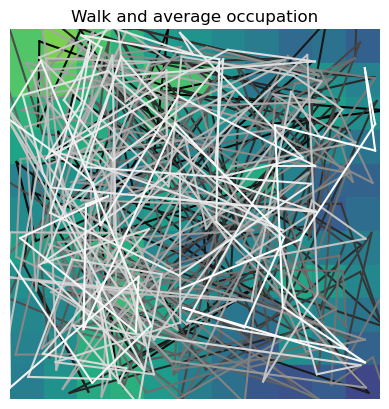

In [12]:
# Plot occupation per location, then add walks on top
ax = plot.plot_map(environments[env_to_plot], np.array(occupation[env_to_plot])/sum(occupation[env_to_plot])*environments[env_to_plot].n_locations, 
                   min_val=0, max_val=2, ax=None, shape='square', radius=1/np.sqrt(environments[env_to_plot].n_locations))
ax = plot.plot_walk(environments[env_to_plot], walks[env_to_plot], ax=ax, n_steps=max(1, int(len(walks[env_to_plot])/500)))
plt.title('Walk and average occupation')